# MLP

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
names_f = '../../data/names.txt'
words = open(names_f, 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
print(f'There are: {len(words)} words.')

There are: 32033 words.


In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Build Dataset

In [5]:
block_size = 10 # context lengths, i.e. how many characters are used to predict the next one
X, Y = [], []

for w in words[:5]:
    print(w)
    # Expand the [0] list, 'block_size' times
    # if block_size = 3 -> context = [0, 0, 0]
    context = [0] * block_size
    for ch in w + '.':
        #print(f'{ch=}')
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
.......... ---> e
.........e ---> m
........em ---> m
.......emm ---> a
......emma ---> .
olivia
.......... ---> o
.........o ---> l
........ol ---> i
.......oli ---> v
......oliv ---> i
.....olivi ---> a
....olivia ---> .
ava
.......... ---> a
.........a ---> v
........av ---> a
.......ava ---> .
isabella
.......... ---> i
.........i ---> s
........is ---> a
.......isa ---> b
......isab ---> e
.....isabe ---> l
....isabel ---> l
...isabell ---> a
..isabella ---> .
sophia
.......... ---> s
.........s ---> o
........so ---> p
.......sop ---> h
......soph ---> i
.....sophi ---> a
....sophia ---> .


In [6]:
print(f'{X.shape=} | {Y.shape=}')

X.shape=torch.Size([32, 10]) | Y.shape=torch.Size([32])


In [7]:
X

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  5, 13],
        [ 0,  0,  0,  0,  0,  0,  0,  5, 13, 13],
        [ 0,  0,  0,  0,  0,  0,  5, 13, 13,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 15],
        [ 0,  0,  0,  0,  0,  0,  0,  0, 15, 12],
        [ 0,  0,  0,  0,  0,  0,  0, 15, 12,  9],
        [ 0,  0,  0,  0,  0,  0, 15, 12,  9, 22],
        [ 0,  0,  0,  0,  0, 15, 12,  9, 22,  9],
        [ 0,  0,  0,  0, 15, 12,  9, 22,  9,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  1, 22],
        [ 0,  0,  0,  0,  0,  0,  0,  1, 22,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  9],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  9, 19],
        [ 0,  0,  0,  0,  0,  0,  0,  9, 19,  1],


In [8]:
n_items = X.shape[0]
print(n_items)

32


In [9]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [10]:
# 2-d embedding for each of the 27 characters
d_embeddings = 2
C = torch.randn((27, d_embeddings))
C

tensor([[-1.1773,  0.4927],
        [-0.5781, -0.5851],
        [ 0.9133, -0.4603],
        [ 1.0580,  0.9109],
        [ 0.4994,  0.8342],
        [-0.3661, -0.3469],
        [-1.7396,  0.5077],
        [-1.0498,  1.4924],
        [ 1.3084, -1.6258],
        [ 1.1259,  1.5697],
        [-0.8676,  0.4514],
        [-0.7129,  0.5068],
        [-1.5878, -0.0348],
        [-0.1823,  0.1219],
        [-0.5424,  1.1216],
        [-0.8683,  0.5625],
        [ 2.0244,  1.4541],
        [-0.7386, -0.2231],
        [ 1.5364,  0.7794],
        [ 0.5587, -1.7991],
        [-0.1317,  0.8148],
        [-0.4672, -0.1541],
        [-0.7528, -0.6744],
        [ 0.2784,  0.0661],
        [-1.1805, -0.4419],
        [ 0.8606,  1.0435],
        [-0.8856, -1.4693]])

## Illustration of how to embed a single integer

In [11]:
idx: int = 5
C[5]

tensor([-0.3661, -0.3469])

In [12]:
int_five_one_hot = F.one_hot(torch.tensor(5), num_classes=27).float()

In [13]:
print(f'{int_five_one_hot=} \n dtype: {int_five_one_hot.dtype} | Shape: {int_five_one_hot.shape}')

int_five_one_hot=tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]) 
 dtype: torch.float32 | Shape: torch.Size([27])


In [14]:
int_five_one_hot @ C

tensor([-0.3661, -0.3469])

In [15]:
# We can simply index using lists, with pytorch
C[[4, 5, 6]]

tensor([[ 0.4994,  0.8342],
        [-0.3661, -0.3469],
        [-1.7396,  0.5077]])

In [16]:
# This also works with tensors
C[torch.tensor([4, 5, 6])]

tensor([[ 0.4994,  0.8342],
        [-0.3661, -0.3469],
        [-1.7396,  0.5077]])

In [17]:
C[X]

tensor([[[-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927]],

        [[-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-0.3661, -0.3469]],

        [[-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-0.3661, -0.3469],
         [-0.1823,  0.1219]],

        [[-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
         [-1.1773,  0.4927],
        

In [18]:
# C[X] gives us the last dim -> '2', which is the embedding vector
# We have it 32 times. And for each of the 32, we have 10 (block_size) values
C[X].shape

torch.Size([32, 10, 2])

In [19]:
X[13, 2]

tensor(0)

In [20]:
C[X][13, 2]

tensor([-1.1773,  0.4927])

In [21]:
C[0]

tensor([-1.1773,  0.4927])

## Embed X into C

In [22]:
embed = C[X]
embed.shape

torch.Size([32, 10, 2])

## Hidden Layer

In [23]:
W1 = torch.randn(((d_embeddings * block_size), 100))
b1 = torch.randn(100)

We want to embed @ W1 + b

But the shapes don't match! Embed is (32, 10, 2) while W1 is (10*2, 100)

### Using torch.unbind and torch.cat

In [24]:
# unbind the tensor on the 1-st dim ->
unbindded_embed = torch.unbind(embed, 1)
print(f'Unbindded tensor has: {len(unbindded_embed)} elements.')
assert block_size == len(unbindded_embed), 'Mismatch between unbindded len and block_size'

Unbindded tensor has: 10 elements.


In [25]:
# concatenate
print(torch.cat(unbindded_embed, 1).shape)

torch.Size([32, 20])


### Using view

In [26]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [27]:
a.shape

torch.Size([18])

In [28]:
a.view(2, 9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [29]:
a.view(9, 2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [30]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [31]:
embed.view(n_items, block_size * d_embeddings)

tensor([[-1.1773,  0.4927, -1.1773,  0.4927, -1.1773,  0.4927, -1.1773,  0.4927,
         -1.1773,  0.4927, -1.1773,  0.4927, -1.1773,  0.4927, -1.1773,  0.4927,
         -1.1773,  0.4927, -1.1773,  0.4927],
        [-1.1773,  0.4927, -1.1773,  0.4927, -1.1773,  0.4927, -1.1773,  0.4927,
         -1.1773,  0.4927, -1.1773,  0.4927, -1.1773,  0.4927, -1.1773,  0.4927,
         -1.1773,  0.4927, -0.3661, -0.3469],
        [-1.1773,  0.4927, -1.1773,  0.4927, -1.1773,  0.4927, -1.1773,  0.4927,
         -1.1773,  0.4927, -1.1773,  0.4927, -1.1773,  0.4927, -1.1773,  0.4927,
         -0.3661, -0.3469, -0.1823,  0.1219],
        [-1.1773,  0.4927, -1.1773,  0.4927, -1.1773,  0.4927, -1.1773,  0.4927,
         -1.1773,  0.4927, -1.1773,  0.4927, -1.1773,  0.4927, -0.3661, -0.3469,
         -0.1823,  0.1219, -0.1823,  0.1219],
        [-1.1773,  0.4927, -1.1773,  0.4927, -1.1773,  0.4927, -1.1773,  0.4927,
         -1.1773,  0.4927, -1.1773,  0.4927, -0.3661, -0.3469, -0.1823,  0.1219,
      

In [32]:
assert embed.view(n_items, block_size * d_embeddings).shape == torch.cat(unbindded_embed, 1).shape
embed.view(n_items, block_size * d_embeddings).shape

torch.Size([32, 20])

In [33]:
embed.view(n_items, block_size * d_embeddings) @ W1 + b1

tensor([[-0.0882, -5.5745, -4.1221,  ...,  5.8177, -1.8723, -3.5602],
        [-0.4591, -3.8418, -3.9892,  ...,  6.4004, -1.6177, -3.8330],
        [-1.4240, -5.3042, -3.9455,  ...,  6.4636, -3.6290, -3.4774],
        ...,
        [-1.4680, -6.0398, -0.7914,  ...,  4.3061,  1.4460, -1.0462],
        [-2.4356, -5.0967,  1.6574,  ...,  3.2779, -8.2057, -3.6018],
        [ 8.2215, -3.0220, -2.2719,  ..., -4.4288, -2.9951,  4.8295]])

In [34]:
# '-1' means that pytorch will infer what the value should be
embed.view(-1, block_size * d_embeddings) @ W1 + b1

tensor([[-0.0882, -5.5745, -4.1221,  ...,  5.8177, -1.8723, -3.5602],
        [-0.4591, -3.8418, -3.9892,  ...,  6.4004, -1.6177, -3.8330],
        [-1.4240, -5.3042, -3.9455,  ...,  6.4636, -3.6290, -3.4774],
        ...,
        [-1.4680, -6.0398, -0.7914,  ...,  4.3061,  1.4460, -1.0462],
        [-2.4356, -5.0967,  1.6574,  ...,  3.2779, -8.2057, -3.6018],
        [ 8.2215, -3.0220, -2.2719,  ..., -4.4288, -2.9951,  4.8295]])

In [35]:
h = torch.tanh(embed.view(-1, block_size * d_embeddings) @ W1 + b1)

In [36]:
h.shape

torch.Size([32, 100])

### Devil's in the details: broadcasting

In [37]:
(embed.view(-1, block_size * d_embeddings) @ W1).shape

torch.Size([32, 100])

In [38]:
b1.shape

torch.Size([100])

In [39]:
# 32, 100
# 100 --> broadcast by aligning to the right --> 1, 100
# Our implementation is correct.

### Final Layer

In [40]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [41]:
h.shape

torch.Size([32, 100])

In [42]:
W2.shape

torch.Size([100, 27])

In [43]:
b2.shape

torch.Size([27])

In [44]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [45]:
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdims=True)

In [46]:
prob.shape

torch.Size([32, 27])

In [47]:
# every row of prob sums to 1
prob[0].sum()

tensor(1.)

In [50]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [51]:
# For each item in the dataset (now, only 32 items because we took the first 5 names), what is the index of the char
# e.g. the 0-th char has index 5 -> 'e' ('.' : 0, 'a':1, 'b':2,... 'e':5)
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [52]:
Y.shape

torch.Size([32])

Retrieve the probability assigned with each item from Y.

In [54]:
# index in a 2D matrix: prob
# torch.arange(32) has the ROWS indices : 0, 1, ..., 31
# Y has the column indices
# for each position 'i', we get the prob[i, Y[i]] element
prob[torch.arange(32), Y]

tensor([1.6079e-03, 4.8141e-04, 2.5674e-07, 2.0393e-01, 2.1825e-06, 4.3978e-03,
        2.2123e-13, 2.1851e-04, 1.5363e-05, 5.2361e-01, 9.1731e-07, 2.4753e-09,
        5.9683e-06, 1.9779e-06, 9.6531e-04, 9.1735e-13, 2.3053e-04, 6.9018e-10,
        1.9456e-05, 1.7315e-10, 7.1387e-03, 1.2986e-06, 6.0755e-10, 5.5041e-12,
        3.3007e-05, 5.2229e-12, 3.8329e-05, 4.3876e-19, 1.3378e-10, 1.0000e+00,
        4.7411e-07, 8.8106e-06])

In [60]:
# This is exactly the same as doing the below:

result = []
for i in range(32):
    result.append(prob[i, Y[i]])
result = torch.tensor([prob[i, Y[i]] for i in range(32)])

assert torch.all(result == prob[torch.arange(32), Y])

In [63]:
loss = - prob[torch.arange(32), Y].log().mean()
loss

tensor(14.3203)

### Wrapping up the layers and the loss

In [64]:
X.shape, Y.shape

(torch.Size([32, 10]), torch.Size([32]))

In [69]:
embed_size = 2
num_blocks = 10
input_size = embed_size * num_blocks

In [70]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((input_size , 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [71]:
# model size
sum(p.nelement() for p in parameters)

4881

In [72]:
# We index into C, using X.
# This means that for each value in X (there are 32 x 10 of them), We find the embeddings, a 2D vector in C (there are 2 of them)
emb = C[X] # (32, 10, 2)
h = torch.tanh(emb.view(-1, input_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(16.5210)

In [74]:
# We can do the same directly in PyTorch
# better forward, backward pass
# good behaviour with respect to numerical stability
loss_ce = F.cross_entropy(logits, Y)
loss_ce

assert loss == loss_ce

### Backward pass

In [76]:
for p in parameters:
    p.requires_grad = True

In [80]:
for _ in range(1000):
    # FORWARD pass
    emb = C[X] # (32, 10, 2)
    h = torch.tanh(emb.view(-1, input_size) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # BACKWARD pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

0.3152937889099121
0.31463170051574707
0.31398314237594604
0.3133479952812195
0.3127257823944092
0.31211626529693604
0.3115190267562866
0.3109337389469147
0.3103600740432739
0.3097977638244629
0.3092464506626129
0.3087058663368225
0.30817562341690063
0.3076554238796234
0.3071451187133789
0.30664417147636414
0.3061526119709015
0.3056699335575104
0.3051961064338684
0.30473050475120544
0.3042733669281006
0.3038240671157837
0.30338260531425476
0.30294859409332275
0.30252203345298767
0.30210256576538086
0.30169010162353516
0.3012843132019043
0.3008851110935211
0.3004922866821289
0.3001057505607605
0.299725204706192
0.2993506193161011
0.29898181557655334
0.2986186742782593
0.2982609272003174
0.2979086637496948
0.29756149649620056
0.2972194254398346
0.2968823313713074
0.2965501546859741
0.2962226867675781
0.2958998680114746
0.2955816090106964
0.29526764154434204
0.2949581444263458
0.29465287923812866
0.2943517565727234
0.29405462741851807
0.29376158118247986
0.29347240924835205
0.293186962604

In [81]:
# predicted index of char
logits.max(1)

torch.return_types.max(
values=tensor([ 6.9500, 14.2211, 12.2372, 13.8298, 14.2894,  6.9500, 16.6133, 13.2638,
        14.5510, 17.9793, 16.8200, 15.7818,  6.9500, 15.8600, 15.5706, 18.2174,
         6.9500, 10.4622, 14.4966, 14.6525, 18.8223, 17.6378, 13.2541, 12.1695,
        18.4192,  6.9500, 12.3635, 15.3949, 14.4858, 16.0893, 18.5848, 15.5853],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 13, 13,  1,  0,  1, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  1, 19,
         1,  2,  5, 12, 12,  1,  0,  1, 15, 16,  8,  9,  1,  0]))

In [82]:
# Actual index of the char
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

## Build the full dataset

In [95]:
block_size = 10 # context lengths, i.e. how many characters are used to predict the next one
X, Y = [], []

for w in words:
    # Expand the [0] list, 'block_size' times
    # if block_size = 3 -> context = [0, 0, 0]
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [96]:
X.shape, Y.shape

(torch.Size([228146, 10]), torch.Size([228146]))

In [97]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((input_size , 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [98]:
embed_size = 2
num_blocks = 10
input_size = embed_size * num_blocks

In [99]:
for p in parameters:
    p.requires_grad = True

If we run the optimization, notice that we have 228146 data instead of 32 (the first 5 words) as previously.

In [101]:
for _ in range(10):
    # FORWARD pass
    emb = C[X] # (228146, 10, 2)
    h = torch.tanh(emb.view(-1, input_size) @ W1 + b1) # (228146, 100)
    logits = h @ W2 + b2 # (228146, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # BACKWARD pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

3.4873337745666504
3.482213258743286
3.4760725498199463
3.471190929412842
3.4650039672851562
3.4603657722473145
3.4541332721710205
3.4497435092926025
3.4434657096862793
3.4393277168273926


The previous experiment was quite slow. Indeed, one other approach is to update the weights more frequently using mini batches of data instead of the full dataset.

In [104]:
# generate 32 items, having values between [0, number_of_items_in_ds] (which is X.shape[0])
torch.randint(0, X.shape[0], (32,))

tensor([ 19994,  95891,  17440,  51422, 161884,  88952, 136438,   2143,  41147,
        162005,  45042, 155019,  23405, 101590, 155540,  18112,  18931, 152711,
        171323, 224333, 226827, 227228, 107659,  38754, 194986, 147755, 170851,
        152905, 155540,   1650, 159047, 181850])

In [109]:
for _ in range(10000):
    # mini-batch
    ix = torch.randint(0, X.shape[0], (32,))

    # FORWARD pass
    # We only keep certain indices in X
    emb = C[X[ix]] # (32, 10, 2)
    h = torch.tanh(emb.view(-1, input_size) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])  # also index into Y

    # BACKWARD pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

# This is the loss of the last mini batch
print(loss.item())

2.2034764289855957
2.5403385162353516
2.379570245742798
2.147184371948242
2.327517032623291
2.6888649463653564
2.440186023712158
2.6071979999542236
2.5586774349212646
2.363081216812134
2.761356830596924
2.335545301437378
2.8278121948242188
2.643310308456421
2.326631784439087
2.8252358436584473
2.1459710597991943
2.0938942432403564
2.2748162746429443
2.8386008739471436
2.450314998626709
2.385634183883667
2.7007620334625244
2.4120938777923584
2.4204113483428955
2.53130841255188
2.326991081237793
2.6403257846832275
2.7865865230560303
2.6601505279541016
2.477928400039673
2.4943718910217285
2.7594501972198486
2.474186897277832
2.6363773345947266
2.3535871505737305
2.8778467178344727
1.9706536531448364
2.07621169090271
2.497204542160034
2.722421407699585
2.1426148414611816
2.657443046569824
2.3543543815612793
2.2326760292053223
2.3515257835388184
2.647542953491211
2.425784111022949
2.2618677616119385
2.345677137374878
2.5516624450683594
2.330324411392212
2.807919502258301
2.735731363296509
2

In [110]:
# We want the loss on ALL the data. Not only on the last mini batch
emb = C[X]
h = torch.tanh(emb.view(-1, num_blocks * embed_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4148, grad_fn=<NllLossBackward0>)

### Find optimal initial LR

In [111]:
torch.linspace(0.001, 1, 1000)

tensor([0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090,
        0.0100, 0.0110, 0.0120, 0.0130, 0.0140, 0.0150, 0.0160, 0.0170, 0.0180,
        0.0190, 0.0200, 0.0210, 0.0220, 0.0230, 0.0240, 0.0250, 0.0260, 0.0270,
        0.0280, 0.0290, 0.0300, 0.0310, 0.0320, 0.0330, 0.0340, 0.0350, 0.0360,
        0.0370, 0.0380, 0.0390, 0.0400, 0.0410, 0.0420, 0.0430, 0.0440, 0.0450,
        0.0460, 0.0470, 0.0480, 0.0490, 0.0500, 0.0510, 0.0520, 0.0530, 0.0540,
        0.0550, 0.0560, 0.0570, 0.0580, 0.0590, 0.0600, 0.0610, 0.0620, 0.0630,
        0.0640, 0.0650, 0.0660, 0.0670, 0.0680, 0.0690, 0.0700, 0.0710, 0.0720,
        0.0730, 0.0740, 0.0750, 0.0760, 0.0770, 0.0780, 0.0790, 0.0800, 0.0810,
        0.0820, 0.0830, 0.0840, 0.0850, 0.0860, 0.0870, 0.0880, 0.0890, 0.0900,
        0.0910, 0.0920, 0.0930, 0.0940, 0.0950, 0.0960, 0.0970, 0.0980, 0.0990,
        0.1000, 0.1010, 0.1020, 0.1030, 0.1040, 0.1050, 0.1060, 0.1070, 0.1080,
        0.1090, 0.1100, 0.1110, 0.1120, 

We want to be spaced exponentially between the min (0.001) and max (1.0) LR candidates

In [112]:
# create a linear range over the power of the learning rate
# 10 ** (-3) = 0.001 and 10 ** (0) = 1.
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [120]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((input_size , 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [121]:
lr_i = []
loss_i = []

for i in range(1000):
    # mini-batch
    ix = torch.randint(0, X.shape[0], (32,))

    # FORWARD pass
    # We only keep certain indices in X
    emb = C[X[ix]] # (32, 10, 2)
    h = torch.tanh(emb.view(-1, input_size) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])  # also index into Y

    # BACKWARD pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    lre_i = lre[i]
    for p in parameters:
        p.data += -lr * p.grad

    # stats
    lr_i.append(lre_i)
    loss_i.append(loss.item())

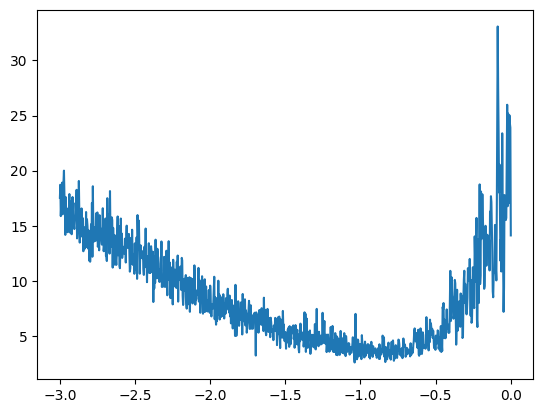

In [122]:
plt.plot(lr_i, loss_i)

In [125]:
best_loss_idx = loss_i.index(min(loss_i))

In [127]:
lre = lr_i[best_loss_idx]
lre

tensor(-1.0390)

In [129]:
lr = 10**(lre.item())
lr

0.091403112384853

Now, use our best LR

In [130]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((input_size , 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [131]:
for _ in range(10000):
    # mini-batch
    ix = torch.randint(0, X.shape[0], (32,))

    # FORWARD pass
    # We only keep certain indices in X
    emb = C[X[ix]] # (32, 10, 2)
    h = torch.tanh(emb.view(-1, input_size) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])  # also index into Y

    # BACKWARD pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -lr * p.grad

# This is the loss of the last mini batch
print(loss.item())

2.5552728176116943


In [132]:
# Loss on the full dataset
emb = C[X]
h = torch.tanh(emb.view(-1, num_blocks * embed_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.6095, grad_fn=<NllLossBackward0>)

# Split the Dataset

In [134]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

80/10/10 split

In [135]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [142]:
input_size = 2 * 3

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((input_size , 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

## Train only on the Training Dataset

In [143]:
for _ in range(10000):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # FORWARD pass
    # We only keep certain indices in X
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, input_size) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])  # also index into Y

    # BACKWARD pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -lr * p.grad

# Evaluate our loss on the Dev Dataset

In [145]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4895, grad_fn=<NllLossBackward0>)

In [146]:
# Also check the loss on the Train set to see if we are overfitting (i.e., Train set would be much lower)
emb = C[Xtr]
h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4918, grad_fn=<NllLossBackward0>)

We observe that the loss is roughly the same. This means we are underfitting

## Create a Bigger Model

In [147]:
input_size = 2 * 3

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((input_size , 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [149]:
# model size is now bigger
print(sum(p.nelement() for p in parameters))

10281


In [153]:
lr_i = []
loss_i = []
step_i = []

for i in range(50000):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # FORWARD pass
    # We only keep certain indices in X
    emb = C[Xtr[ix]] # (32, 10, 2)
    h = torch.tanh(emb.view(-1, input_size) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])  # also index into Y

    # BACKWARD pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -lr * p.grad

    # stats
    step_i.append(i)
    loss_i.append(loss.item())

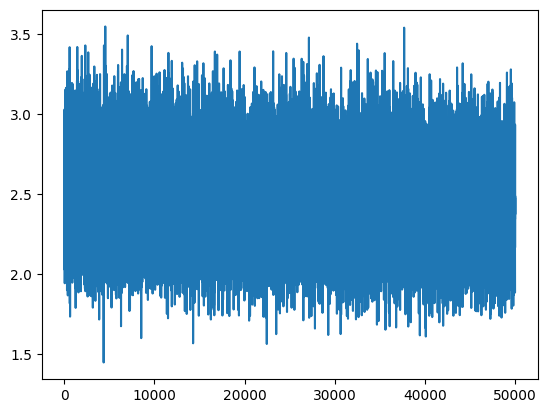

In [154]:
plt.plot(step_i, loss_i)

In [155]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3541, grad_fn=<NllLossBackward0>)

## Visualize embeddings locations in 2D

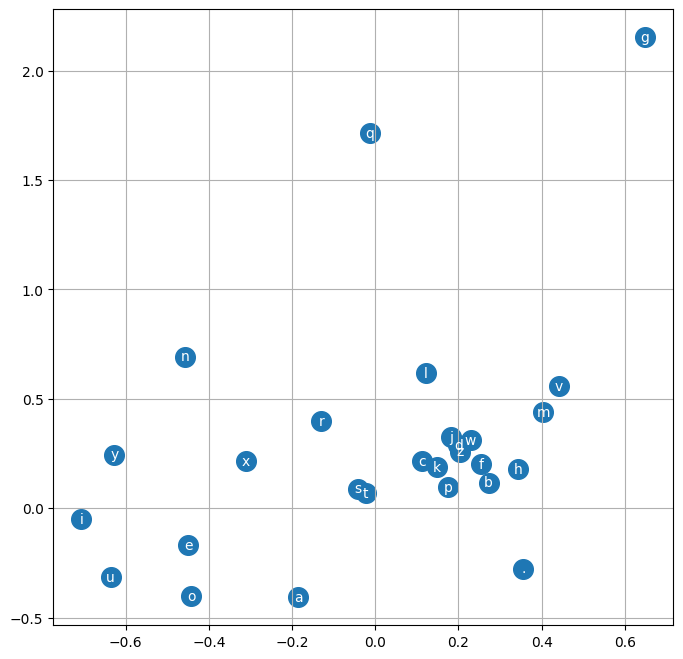

In [156]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

## Increase the embeddings size per char

In [157]:
d_embed = 10
input_size = d_embed * 3 # we keep the number of blocks to 3

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, d_embed), generator=g)
W1 = torch.randn((input_size , 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [158]:
# model size is now bigger
print(sum(p.nelement() for p in parameters))

17697


In [159]:
lr_i = []
loss_i = []
step_i = []

In [164]:
num_it = 50000
for i in range(num_it):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # FORWARD pass
    # We only keep certain indices in X
    emb = C[Xtr[ix]] # (32, 10, 2)
    h = torch.tanh(emb.view(-1, input_size) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])  # also index into Y

    # BACKWARD pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < num_it // 2 else lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # stats
    step_i.append(i)
    loss_i.append(loss.log10().item())

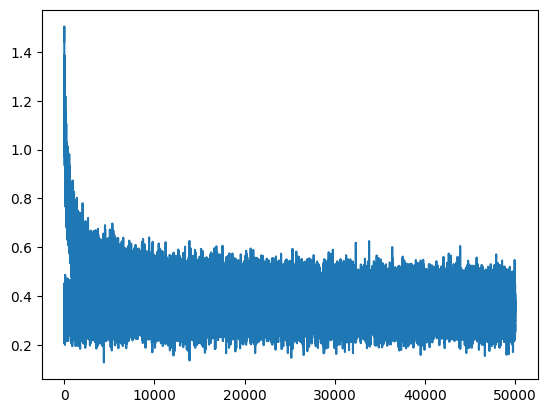

In [165]:
# plot the log loss
plt.plot(step_i, loss_i)

In [166]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2250, grad_fn=<NllLossBackward0>)

# Sampling

In [167]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mona.
mayah.
see.
mel.
ryah.
rethan.
endrlen.
adery.
melin.
shi.
jen.
eden.
esmanar.
kayzion.
karin.
shdynrishiriel.
kinde.
jeliperceron.
ube.
ged.
